In [11]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import torch
# from tqdm import tqdm
from torch_geometric.utils import to_networkx
import networkx as nx
from gnn import GNN
import matplotlib.pyplot as plt
import os
import numpy as np
from gnn import GNN
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric.data import Data, Batch
import plotly.express as px
import matplotlib.colors as mcolors
import random
import pickle

if not os.path.isdir("figures"): os.mkdir("figures")

In [12]:
atom_indices = {
    0: "C",
    1: "N",
    2: "O",
    3: "F",
    4: "I",
    5: "Cl",
    6: "Br",
}

edge_indices = {
    0: "aromatic",
    1: "single",
    2: "double",
    3: "triple",
}

atom_colors = {
    0: "#9b5fe0",
    1: "#16a4d8",
    2: "#60dbe8",
    3: "#efdf48",
    4: "#f9a52c",
    5: "#d64e11",
    6: "#8bd346",
}

dataset = TUDataset(root='data/TUDataset', name='MUTAG')
loader = DataLoader(dataset, batch_size=64)
molecules = True
model_path = "models/MUTAG_model.pth"

In [13]:
with open("data/OurMotifs/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
molecules = False
model_path = "models/OurMotifs_model.pth"

In [14]:
num_node_features = dataset[0].x.shape[1]
node_colors = {i:c for i,c in enumerate(random.choices(list(mcolors.CSS4_COLORS.values()), k=num_node_features))}
node_colors

{0: '#B8860B', 1: '#ADFF2F', 2: '#B8860B', 3: '#DAA520', 4: '#7FFFD4'}

In [15]:
nn = torch.load(model_path)
nn.eval()

GNN(
  (layers): ModuleDict(
    (Conv_0): SAGEConv(5, 4, aggr=sum)
    (Conv_0_Relu): ReLU()
    (Conv_1): SAGEConv(4, 4, aggr=sum)
    (Conv_1_Relu): ReLU()
    (Aggregation): SumAggregation()
    (Lin_0): Linear(in_features=4, out_features=4, bias=True)
    (Lin_0_Relu): ReLU()
    (Lin_Output): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [16]:
nn.float()
all_outputs = []
max_output_value = -float("inf")
for data in dataset:
    outputs = nn(data).detach().numpy()
    all_outputs.append(outputs)

    all_activations = [output for _, output in nn.get_all_layer_outputs(data)]
    max_output_value = max(max_output_value, max(float(torch.max(activation)) for activation in all_activations))
print("Max Output Value:", max_output_value)
    


all_outputs = np.concatenate(all_outputs, axis=0)
for i in range(all_outputs.shape[-1]):
    px.histogram(all_outputs[:, i], title=f"Class {i} Logit Distribution").show()

Max Output Value: 54.59297180175781


In [17]:
index = 1 #"Final"
A = np.load(f"./solutions/A_{index}.npy")
X = np.load(f"./solutions/X_{index}.npy")

In [18]:
X

array([[-0., -0., -0.,  1., -0.],
       [-0., -0., -0.,  1., -0.],
       [-0., -0., -0.,  1., -0.],
       [-0., -0., -0.,  1., -0.],
       [-0., -0., -0.,  1., -0.],
       [-0., -0., -0.,  1., -0.],
       [-0., -0., -0.,  1., -0.],
       [-0., -0., -0.,  1., -0.],
       [-0., -0., -0.,  1., -0.],
       [-0., -0., -0.,  1., -0.]])

In [19]:
G = nx.from_numpy_array(A, create_using=nx.Graph)

print(G.edges)

labels = dict(zip(range(X.shape[0]), map(atom_indices.get, np.argmax(X, axis=1))))
fig, ax = plt.subplots()
pos = nx.spring_layout(G, seed=7)
x_indices = np.argmax(X, axis=1)
node_color = list(map((atom_colors if molecules else node_colors).get, x_indices))
nx.draw_networkx(G, pos=pos, with_labels=True, labels=labels, node_color=node_color)
plt.close()


[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9)]


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['#ADFF2F', None, '#ADFF2F', '#7FFFD4', '#B8860B', '#B8860B', '#B8860B', None, '#B8860B', None]

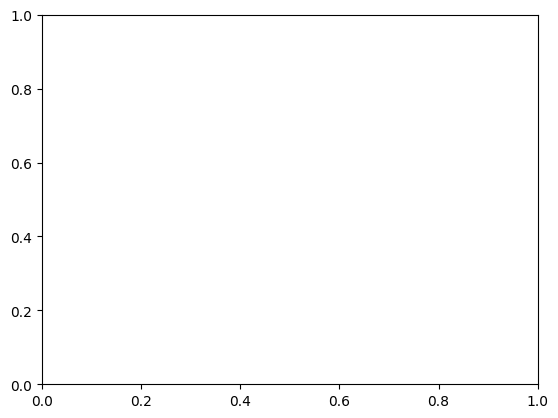

In [20]:
folder = "figures"
for i in range(20):
    A = np.load(f"./solutions/A_{i}.npy")
    X = np.load(f"./solutions/X_{i}.npy")
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)

    labels = dict(zip(range(X.shape[0]), map(atom_indices.get, np.argmax(X, axis=1)))) if molecules else dict(zip(range(X.shape[0]), np.argmax(X, axis=1)))
    fig, ax = plt.subplots()
    # pos = nx.circular_layout(G)
    pos = nx.spring_layout(G, seed=7)
    x_indices = np.argmax(X, axis=1)
    node_color = list(map((atom_colors if molecules else node_colors).get, x_indices))
    nx.draw_networkx(G, pos=pos, with_labels=True, labels=labels, node_color=node_color)

    
    plt.savefig(folder + "/file%02d.png" % i)
    plt.close()

# def generate_video(img):
#     for i in range(len(img)):
#         plt.imshow(img[i], cmap=cm.Greys_r)
#         plt.savefig(folder + "/file%02d.png" % i)

import subprocess
import glob
os.chdir(folder)
subprocess.call([
    'ffmpeg', '-framerate', '4', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p', '-y',
    'graph_steps.mp4'
])
for file_name in glob.glob("*.png"):
    os.remove(file_name)
os.chdir("..")

In [ ]:
def to_batch(X, A):
    g = dict()
    g["edge_index"], g["edge_weight"] = dense_to_sparse(A)
    g["x"] = X
    return Batch.from_data_list([Data(**g)])

In [ ]:
nn.double()

GNN(
  (layers): ModuleDict(
    (Conv_0): SAGEConv(7, 16, aggr=mean)
    (Conv_0_Relu): ReLU()
    (Conv_1): SAGEConv(16, 16, aggr=mean)
    (Conv_1_Relu): ReLU()
    (Conv_2): SAGEConv(16, 16, aggr=mean)
    (Conv_2_Relu): ReLU()
    (Aggregation): MeanAggregation()
    (Lin_0): Linear(in_features=16, out_features=16, bias=True)
    (Lin_0_Relu): ReLU()
    (Lin_1): Linear(in_features=16, out_features=16, bias=True)
    (Lin1Relu): ReLU()
    (Lin_Output): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
# batch = to_batch(torch.Tensor(X).double(), torch.Tensor(A.astype(int)))
# print("NN output given X", nn.get_embedding_outputs(batch)[1].detach().numpy())
print("NN output given X", nn.forwardXA(X, A).detach().numpy())

NN output given X [[101.56579724 -98.91923065]]
